<a href="https://colab.research.google.com/github/m4chiavelli/analis-cuaca-rmse-vs-mse/blob/main/Prediction_lstm_rnn_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import math
import warnings
import time
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

                          Date           Open           High            Low  \
1822 2025-05-12 00:00:00+00:00  104106.960938  105747.453125  100814.406250   
1823 2025-05-13 00:00:00+00:00  102812.492188  104997.421875  101515.093750   
1824 2025-05-14 00:00:00+00:00  104167.328125  104303.562500  102618.296875   
1825 2025-05-15 00:00:00+00:00  103538.828125  104153.617188  101440.812500   
1826 2025-05-16 00:00:00+00:00  103752.484375  104350.664062  103207.664062   

              Close       Volume  Dividends  Stock Splits  
1822  102812.953125  63250475404        0.0           0.0  
1823  104169.812500  52608876410        0.0           0.0  
1824  103539.414062  45956071155        0.0           0.0  
1825  103744.640625  50408241840        0.0           0.0  
1826  103207.664062  50545446912        0.0           0.0  


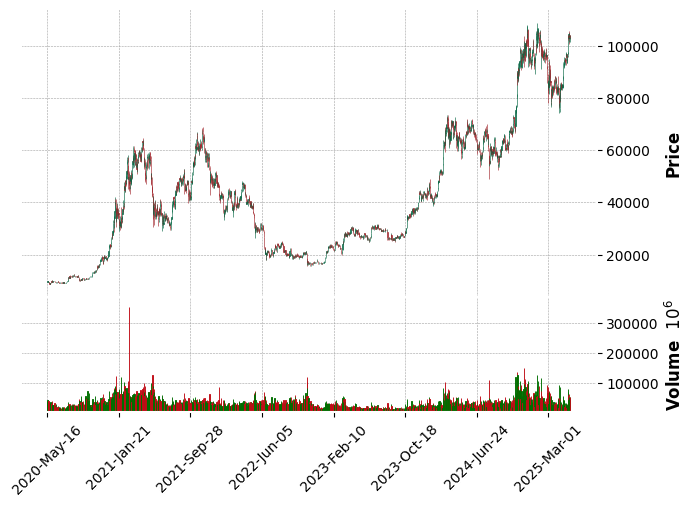

In [ ]:
# Fungsi untuk mengunduh data
def download_btc_data(period='5y'):
    """Download data BTC dari yfinance"""
    btc = yf.Ticker('BTC-USD')
    data = btc.history(period=period)
    time.sleep(2)
    return data

# Simpan data sebagai variable
df = download_btc_data()

df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
print(df.tail())

mpf.plot(df.set_index('Date'), type='candle', volume=True, style='charles')


In [ ]:
def compute_rsi(series, window=14):
    delta = series.diff(1)  # Selisih harga saat ini dengan harga sebelumnya
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Rata-rata kenaikan harga
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Rata-rata penurunan harga
    rs = gain / loss
    return 100 - (100 / (1 + rs))  # Rumus RSI

# Fungsi untuk membuat fitur
def create_features(df):
    """Membuat fitur untuk model"""
    df_feature = df.copy()
    # Hitung moving average
    df_feature['MA7'] = df_feature['Close'].rolling(window=7).mean()
    df_feature['MA14'] = df_feature['Close'].rolling(window=14).mean()
    df_feature['MA30'] = df_feature['Close'].rolling(window=30).mean()
    df_feature['EMA7'] = df_feature['Close'].ewm(span=7, adjust=False).mean()
    df_feature['EMA14'] = df_feature['Close'].ewm(span=14, adjust=False).mean()
    df_feature['EMA30'] = df_feature['Close'].ewm(span=30, adjust=False).mean()
    df_feature['SMA7'] = df_feature['Close'].rolling(window=7).mean()
    df_feature['SMA14'] = df_feature['Close'].rolling(window=14).mean()
    df_feature['SMA30'] = df_feature['Close'].rolling(window=30).mean()

    # Volatilitas (standar deviasi 14 hari)
    df_feature['Volatility'] = df_feature['Close'].rolling(window=14).std()

    # Fitur berdasarkan volume
    df_feature['Volume_Change'] = df_feature['Volume'].pct_change()

    # Fitur berdasarkan harga
    df_feature['Price_Change'] = df_feature['Close'].pct_change()

    # Perbedaan antara harga tertinggi dan terendah (range)
    df_feature['Range'] = df_feature['High'] - df_feature['Low']

    # 🚀 **Tambahkan RSI**
    df_feature['RSI'] = compute_rsi(df_feature['Close'], window=14)

    # Drop NaN values setelah perhitungan
    df_feature = df_feature.dropna()

    return df_feature

In [ ]:
df = create_features(df)
print(df.tail())
print('--------------------------------------')
print('--------------------------------------')
print(df.info())

# df.to_csv()

                                    Open           High            Low  \
Date                                                                     
2025-05-10 00:00:00+00:00  102973.710938  104961.765625  102830.484375   
2025-05-11 00:00:00+00:00  104701.070312  104937.992188  103364.742188   
2025-05-12 00:00:00+00:00  104106.960938  105747.453125  100814.406250   
2025-05-13 00:00:00+00:00  102812.492188  104997.421875  101515.093750   
2025-05-14 00:00:00+00:00  104159.984375  104174.679688  102987.164062   

                                   Close       Volume  Dividends  \
Date                                                               
2025-05-10 00:00:00+00:00  104696.328125  42276713994        0.0   
2025-05-11 00:00:00+00:00  104106.359375  46285517406        0.0   
2025-05-12 00:00:00+00:00  102812.953125  63250475404        0.0   
2025-05-13 00:00:00+00:00  104169.812500  52608876410        0.0   
2025-05-14 00:00:00+00:00  104101.515625  50091610112        0.0   

    

In [ ]:
# Fungsi untuk mempersiapkan data untuk model RNN (LSTM, GRU, SimpleRNN)
def prepare_rnn_data(df, target_col, lookback=60):
    """
    Menyiapkan data untuk model RNN dengan lookback period
    """
    # Pilih fitur yang relevan untuk prediksi harga crypto
    feature_cols = ['Close', 'High', 'Low', 'Volume', 'MA7', 'MA14', 'MA30', 'RSI', 'Volatility', 'Price_Change', 'EMA7', 'EMA14', 'EMA30', 'SMA7', 'SMA14', 'SMA30']
    df = df[feature_cols]
    # Ambil Close Price Target
    target = df['Close'].values.reshape(-1, 1)

    # Normalisasi data
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))

    scaled_features = scaler_features.fit_transform(df)
    scaled_target = scaler_target.fit_transform(target)

    # Membuat dataset dengan lookback period
    X, y = [], []
    for i in range(lookback, len(scaled_features)):
        X.append(scaled_features[i-lookback:i])
        y.append(scaled_target[i])

    # Konversi ke numpy array
    X, y = np.array(X), np.array(y)

    # Split data menjadi train dan test
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler_features, scaler_target

In [ ]:
# Fungsi untuk membuat model LSTM
def create_lstm_model(X_train):
    """
    Membuat model LSTM
    """
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.4))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(units=50,activation='relu'))
    model.add(Dense(units=25,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=1, kernel_regularizer=l2(0.01)))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Fungsi untuk membuat model GRU
def create_gru_model(X_train):
    """
    Membuat model GRU
    """
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Fungsi untuk membuat model SimpleRNN
def create_simple_rnn_model(X_train):
    """
    Membuat model SimpleRNN
    """
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=1, kernel_regularizer=l2(0.01)))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Fungsi untuk melatih dan mengevaluasi model
# df = create_features(df)
def evaluate_models(df, target_col='Close'):
    """
    Melatih dan mengevaluasi model LSTM, GRU, dan SimpleRNN
    """
    # Persiapkan data untuk RNN
    X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn, scaler_features_rnn, scaler_target_rnn = prepare_rnn_data(df, target_col)

    # Simpan hasil test set untuk evaluasi
    y_test_real = scaler_target_rnn.inverse_transform(y_test_rnn)

    # Dictionary untuk menyimpan model dan hasil
    models = {}

    # Model LSTM ----------------------------------------
    print("Melatih model LSTM...")
    lstm_model = create_lstm_model(X_train_rnn)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    lstm_history = lstm_model.fit(
        X_train_rnn, y_train_rnn,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Prediksi LSTM
    lstm_preds = lstm_model.predict(X_test_rnn)
    lstm_preds = scaler_target_rnn.inverse_transform(lstm_preds)

    # Model GRU ----------------------------------------
    print("Melatih model GRU...")
    gru_model = create_gru_model(X_train_rnn)
    gru_history = gru_model.fit(
        X_train_rnn, y_train_rnn,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Prediksi GRU
    gru_preds = gru_model.predict(X_test_rnn)
    gru_preds = scaler_target_rnn.inverse_transform(gru_preds)

    # Model SimpleRNN ----------------------------------------
    print("Melatih model SimpleRNN...")
    simple_rnn_model = create_simple_rnn_model(X_train_rnn)
    simple_rnn_history = simple_rnn_model.fit(
        X_train_rnn, y_train_rnn,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )


    # Prediksi SimpleRNN
    simple_rnn_preds = simple_rnn_model.predict(X_test_rnn)
    simple_rnn_preds = scaler_target_rnn.inverse_transform(simple_rnn_preds)




    # Hitung metrik evaluasi ----------------------------------------
    lstm_rmse = math.sqrt(mean_squared_error(y_test_real, lstm_preds))
    lstm_mae = mean_absolute_error(y_test_real, lstm_preds)
    lstm_mape = mean_absolute_percentage_error(y_test_real, lstm_preds) * 100

    gru_rmse = math.sqrt(mean_squared_error(y_test_real, gru_preds))
    gru_mae = mean_absolute_error(y_test_real, gru_preds)
    gru_mape = mean_absolute_percentage_error(y_test_real, gru_preds) * 100

    simple_rnn_rmse = math.sqrt(mean_squared_error(y_test_real, simple_rnn_preds))
    simple_rnn_mae = mean_absolute_error(y_test_real, simple_rnn_preds)
    simple_rnn_mape = mean_absolute_percentage_error(y_test_real, simple_rnn_preds) * 100

    # Menampilkan hasil
    print("\n===== HASIL EVALUASI =====")
    print(f"LSTM RMSE: ${lstm_rmse:.2f}")
    print(f"LSTM MAE: ${lstm_mae:.2f}")
    print(f"LSTM MAPE: {lstm_mape:.2f}%")
    print("\n")
    print(f"GRU RMSE: ${gru_rmse:.2f}")
    print(f"GRU MAE: ${gru_mae:.2f}")
    print(f"GRU MAPE: {gru_mape:.2f}%")
    print("\n")
    print(f"SimpleRNN RMSE: ${simple_rnn_rmse:.2f}")
    print(f"SimpleRNN MAE: ${simple_rnn_mae:.2f}")
    print(f"SimpleRNN MAPE: {simple_rnn_mape:.2f}%")

    models = {
        "LSTM": lstm_model,
        "GRU": gru_model,
        "SimpleRNN": simple_rnn_model
    }

    # Save model tanpa retraining
    lstm_model.save("lstm_model.h5")
    gru_model.save("gru_model.h5")
    simple_rnn_model.save("simple_rnn_model.h5")

    # Return
    return lstm_model, gru_model, simple_rnn_model, scaler_features_rnn, scaler_target_rnn


lstm_model, gru_model, simple_rnn_model, scaler_features_rnn, scaler_target_rnn = evaluate_models(df)


In [ ]:
# Data evaluasi
models = ['LSTM', 'GRU', 'SimpleRNN']
rmse = [11374.31, 4801.09, 19420.51]
mae = [9184.63, 3925.51, 15330.12]
mape = [10.63, 4.79, 17.35]

# Plot perbandingan
plt.figure(figsize=(10, 6))

# Plot RMSE
plt.plot(models, rmse, marker='o', linestyle='-', color='r', label='RMSE')

# Plot MAE
plt.plot(models, mae, marker='s', linestyle='-', color='g', label='MAE')

# Plot MAPE
plt.plot(models, mape, marker='d', linestyle='-', color='b', label='MAPE')

# Label dan judul
plt.xlabel('Model')
plt.ylabel('Error Metrics')
plt.title('Perbandingan RMSE, MAE, dan MAPE pada LSTM, GRU, dan SimpleRNN')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Tampilkan plot
plt.show()


In [ ]:
def predict_future_prices_lstm(models, df, scaler_features, scaler_target, lookback=60, future_days=30):


In [ ]:
def predict_future_prices_gru(models, df, scaler_features, scaler_target, lookback=60, future_days=30):
    """
    Memprediksi harga Bitcoin 30 hari ke depan menggunakan model GRU yang sudah dilatih.
    """
    # Ambil data terakhir sebagai input awal
    recent_data = df.iloc[-lookback:][['Close', 'High', 'Low', 'Volume', 'MA7', 'MA14', 'MA30', 'RSI', 'Volatility', 'Price_Change', 'EMA7', 'EMA14', 'EMA30', 'SMA7', 'SMA14', 'SMA30']].values

    # Scaling data untuk input model
    recent_data_scaled = scaler_features.transform(recent_data)

    # Inisialisasi input untuk prediksi pertama
    future_input = np.array([recent_data_scaled])  # Bentuk (1, lookback, fitur)

    future_predictions = []

    # Prediksi harga pertama (hari ke-0) menggunakan harga saat ini
    first_pred_scaled = models.predict(future_input)  # Prediksi satu hari ke depan
    future_predictions.append(first_pred_scaled[0][0])  # Simpan prediksi hari ke-0

    # Update input dengan menambahkan prediksi dan menggeser data untuk hari-hari berikutnya
    for _ in range(1, future_days):
        # Update input dengan prediksi hari sebelumnya dan geser data
        new_input = np.append(future_input[0][1:], [[*recent_data_scaled[-1, :-1], future_predictions[-1]]], axis=0)
        future_input = np.array([new_input])  # Perbarui input untuk prediksi selanjutnya

        # Prediksi harga berikutnya
        pred_scaled = models.predict(future_input)  # Prediksi satu hari ke depan
        future_predictions.append(pred_scaled[0][0])  # Simpan prediksi hari berikutnya

    # Denormalisasi hasil prediksi
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler_target.inverse_transform(future_predictions)

    return future_predictions

# Prediksi 30 hari ke depan dengan model GRU
future_prices_gru = predict_future_prices_gru(gru_model, df, scaler_features_rnn, scaler_target_rnn, lookback=60, future_days=30)

# Plot hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(range(len(future_prices_gru)), future_prices_gru, label="Prediksi Harga BTC 30 Hari", color='red', linestyle='dashed')
plt.xlabel("Hari ke-")
plt.ylabel("Harga Bitcoin (USD)")
plt.title("Prediksi Harga Bitcoin 30 Hari ke Depan (GRU)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Prediksi 30 hari ke depan
future_prices_gru = predict_future_prices_gru(gru_model, df, scaler_features_rnn, scaler_target_rnn, lookback=60, future_days=30)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(future_prices_gru)), future_prices_gru, label="Prediksi Harga BTC 30 Hari (GRU)", color='red', linestyle='dashed')
plt.scatter(0, future_prices_gru[0], color='blue', label=f"Harga Hari Ini (${future_prices_gru[0]:.2f})")
plt.xlabel("Hari ke-")
plt.ylabel("Harga Bitcoin (USD)")
plt.title("Prediksi Harga Bitcoin 30 Hari ke Depan (GRU)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Fungsi untuk memuat model yang sudah disimpan
def load_trained_models():
    lstm_model = load_model('lstm_model.h5')
    gru_model = load_model('gru_model.h5')
    simple_rnn_model = load_model('simple_rnn_model.h5')
    return lstm_model, gru_model, simple_rnn_model

# Fungsi untuk memprediksi harga 30 hari ke depan
def predict_future_prices(models, df, scaler_features, scaler_target, lookback=60, future_days=30):
    """
    Memprediksi harga Bitcoin 30 hari ke depan menggunakan model yang telah dilatih.
    """
    # Ambil data terakhir sebagai input awal
    recent_data = df.iloc[-lookback:][['Close', 'High', 'Low', 'Volume', 'MA7', 'MA14', 'MA30', 'RSI', 'Volatility', 'Price_Change', 'EMA7', 'EMA14', 'EMA30', 'SMA7', 'SMA14', 'SMA30']].values
    recent_data_scaled = scaler_features.transform(recent_data)

    # Reshape agar sesuai dengan input model
    future_input = np.array([recent_data_scaled])  # Bentuk (1, lookback, fitur)

    future_predictions = []

    for _ in range(future_days):
        pred_scaled = models.predict(future_input)  # Prediksi satu hari ke depan
        future_predictions.append(pred_scaled[0][0])  # Simpan prediksi

        # Update input dengan menambahkan prediksi dan menggeser data
        new_input = np.append(future_input[0][1:], [[*recent_data_scaled[-1, :-1], pred_scaled[0][0]]], axis=0)
        future_input = np.array([new_input])  # Perbarui input

    # Denormalisasi hasil prediksi
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler_target.inverse_transform(future_predictions)

    return future_predictions

# Load model yang sudah dilatih
lstm_model, gru_model, simple_rnn_model = load_trained_models()

# Prediksi 30 hari ke depan dengan model GRU
future_prices_gru = predict_future_prices(gru_model, df, scaler_features_rnn, scaler_target_rnn, lookback=60, future_days=30)

# Prediksi 30 hari ke depan dengan model LSTM
future_prices_lstm = predict_future_prices(lstm_model, df, scaler_features_rnn, scaler_target_rnn, lookback=60, future_days=30)

# Plot hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(range(len(future_prices_gru)), future_prices_gru, label="Prediksi Harga BTC 30 Hari (GRU)", color='red', linestyle='dashed')
plt.plot(range(len(future_prices_lstm)), future_prices_lstm, label="Prediksi Harga BTC 30 Hari (LSTM)", color='blue', linestyle='dotted')
plt.xlabel("Hari ke-")
plt.ylabel("Harga Bitcoin (USD)")
plt.title("Prediksi Harga Bitcoin 30 Hari ke Depan (GRU vs LSTM)")
plt.legend()
plt.grid()
plt.show()
